In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20231003094404/", (03 October 2023)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/', 'v008.20230821105000/', 'v008.20231003094404/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


In [0]:
import pandas as pd
import pyspark.sql.functions as F

def map_udf(list_of_numbers):
    return [x for x in list_of_numbers if x is not None]
    #a = [x for x in list_of_numbers if x is not None]
    #return sum(a)/len(a)

udf_map = F.udf(map_udf, ArrayType(FloatType()))

def mean_udf(list_of_numbers):
    if len(list_of_numbers) == 0:
        return 0.0
    return sum(list_of_numbers) / len(list_of_numbers)

udf_mean = F.udf(mean_udf, FloatType())

df_sources = spark.read.format("parquet").load(basePath+tablename_sources)
display(df_sources.count(),"\n")

data = df_sources.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))
data = data.withColumn("list_of_numbers", udf_map(F.col("SJR_lst")))
#data = data.withColumn("mean_of_numbers", udf_mean(F.col("list_of_numbers")))
data = data.withColumn('mean_of_numbers', F.element_at(data['list_of_numbers'], -1))


display(data.limit(5))


In [0]:
dd = data.select('mean_of_numbers','SJR_lst','srcid').toPandas()
q1 = dd['mean_of_numbers'].quantile(0.25)
q2 = dd['mean_of_numbers'].quantile(0.50)
q3 = dd['mean_of_numbers'].quantile(0.75)
print(q1," ",q2," ",q3)
#print(dd['srcid'].nunique())

In [0]:
print(len(dd))
print(dd['srcid'].nunique())

In [0]:
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv")
q1 = total['SJR'].quantile(0.25)
q2 = total['SJR'].quantile(0.50)
q3 = total['SJR'].quantile(0.75)
print(q1," ",q2," ",q3)

### This is the journal quantile find criteria

In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','openaccess','issn','source','correspondence','Af')
  newdf = newdf.withColumn('cor_af', first(newdf['correspondence']))
  newdf = newdf.withColumn('cor_coun', F.col('cor_af').getItem('country'))
  #display(newdf.limit(10))
  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2


from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

#display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
#display("len of df_ani in english ",d2.count(),"\n")


newdf = extract_publication_info(d2)

df_class = get_smc_classification(newdf)
#display(df_class.limit(10),"\n")
#display(df_class.count(),"\n")
us_data = df_class.filter(func.col('cor_coun') == 'usa')
display(us_data.count(),"\n")

df_sources = spark.read.format("parquet").load(basePath+tablename_sources)
data = us_data.join(df_sources,'srcid','inner')

newdata = data.select('srcid','metrics_calculations')
newdata = newdata.dropDuplicates(["srcid"])
display(newdata.limit(10),"\n")

16102439'\n'

srcid,metrics_calculations
12029,"List(List(null, null, 142.0, 130.0, null, 16, 0.0, Complete, 1996, 0, 1), List(null, null, 165.0, 159.0, null, 17, 0.0, Complete, 1997, 1, 1), List(null, null, 173.0, 166.0, null, 28, 10.71, Complete, 1998, 1, 2), List(0.767, 1.512, 174.0, 163.0, null, 29, 3.45, Complete, 1999, 1, 1), List(0.599, 1.656, 282.0, 268.0, null, 35, 5.71, Complete, 2000, 1, 1), List(0.626, 0.956, 332.0, 312.0, null, 31, 0.0, Complete, 2001, 0, 1), List(0.789, 0.899, 348.0, 340.0, null, 29, 24.14, Complete, 2002, 1, 1), List(0.813, 0.968, 465.0, 458.0, null, 36, 52.78, Complete, 2003, 2, 2), List(0.829, 1.141, 619.0, 597.0, null, 33, 48.48, Complete, 2004, 0, 0), List(0.724, 1.142, 749.0, 727.0, null, 36, 27.78, Complete, 2005, 2, 2), List(0.957, 1.638, 884.0, 845.0, null, 30, 16.67, Complete, 2006, 0, 0), List(1.113, 1.801, 1043.0, 1020.0, null, 44, 40.91, Complete, 2007, 2, 2), List(0.952, 1.255, 1472.0, 1422.0, null, 50, 24.0, Complete, 2008, 0, 0), List(0.871, 1.312, 1635.0, 1619.0, null, 35, 22.86, Complete, 2009, 0, 0), List(0.889, 1.85, 2056.0, 2012.0, null, 31, 0.0, Complete, 2010, 0, 0), List(1.325, 2.177, 2351.0, 2324.0, List(List(840, 6.1, 75, 137, List(List(1201, List(264, 13), 95), List(3202, List(174, 9), 95), List(3204, List(246, 18), 92)))), 30, 0.0, Complete, 2011, 1, 1), List(1.481, 1.703, 2905.0, 2893.0, List(List(468, 3.7, 73, 126, List(List(3202, List(185, 31), 83), List(1201, List(266, 56), 79), List(3204, List(261, 61), 76)))), 34, 0.0, Complete, 2012, 1, 1), List(1.571, 1.625, 3072.0, 3009.0, List(List(461, 3.8, 78, 120, List(List(1201, List(267, 49), 81), List(3202, List(186, 36), 80), List(3204, List(267, 64), 76)))), 29, 0.0, Complete, 2013, 0, 0), List(1.51, 1.926, 3423.0, 3350.0, List(List(544, 4.9, 79, 112, List(List(3202, List(191, 20), 89), List(1201, List(267, 32), 88), List(3204, List(271, 38), 86)))), 29, 0.0, Complete, 2014, 0, 0), List(1.02, 1.451, 3736.0, 3686.0, List(List(521, 5.0, 78, 105, List(List(1201, List(267, 32), 88), List(3202, List(195, 25), 87), List(3204, List(276, 40), 85)))), 28, 0.0, Complete, 2015, 1, 1), List(1.228, 1.342, 3948.0, 3894.0, List(List(441, 4.2, 86, 105, List(List(1201, List(250, 37), 85), List(3204, List(276, 56), 79), List(3202, List(200, 43), 78)))), 26, 0.0, Complete, 2016, 1, 1), List(1.406, 1.394, 4220.0, 4201.0, List(List(509, 5.0, 84, 101, List(List(1201, List(259, 22), 91), List(3204, List(290, 38), 87), List(3202, List(215, 34), 84)))), 25, 4.0, Complete, 2017, 0, 0), List(1.958, 1.803, 4467.0, 4446.0, List(List(599, 5.7, 76, 106, List(List(1201, List(283, 16), 94), List(3204, List(314, 27), 91), List(3202, List(221, 25), 88)))), 28, 0.0, Complete, 2018, 0, 0), List(1.457, 1.711, 4772.0, 4740.0, List(List(690, 6.4, 81, 108, List(List(1201, List(295, 12), 96), List(3204, List(327, 19), 94), List(3202, List(227, 21), 90)))), 26, 7.69, Complete, 2019, 0, 0), List(1.497, 1.899, 5257.0, 5156.0, List(List(669, 5.3, 87, 127, List(List(1201, List(306, 22), 92), List(3204, List(332, 41), 87), List(3202, List(227, 36), 84)))), 61, 9.84, Complete, 2020, 4, 5), List(1.59, 1.806, 5932.0, 5816.0, List(List(1029, 6.1, 87, 168, List(List(1201, List(376, 21), 94), List(3204, List(341, 33), 90), List(3202, List(230, 37), 84)))), 72, 4.17, Complete, 2021, 1, 1), List(2.279, 2.787, 7354.0, 7212.0, List(List(2002, 9.9, 90, 202, List(List(1201, List(440, 11), 97), List(3204, List(343, 17), 95), List(3202, List(241, 23), 90)))), 83, 10.84, Complete, 2022, 19, 21), List(null, null, 5771.0, 5649.0, List(List(2596, 11.6, 89, 224, List(List(1201, List(440, 5), 98), List(3204, List(343, 10), 97), List(3202, List(241, 14), 94)))), 90, 4.44, In-Progress, 2023, 42, 46))"
12037,"List(List(null, null, 70.0, 70.0, null, 61, 0.0, Complete, 1996, 23, 23), List(null, null, 76.0, 76.0, null, 34, 0.0, Complete, 1997, 9, 10), List(null, null, 78.0, 75.0, null, 48, 0.0, Complete, 1998, 9, 11), List(0.194, 0.0, 93.0, 81.0, null, 37, 0.0, Complete, 1999, 8, 9), List(0.217, 0.287, 9

In [0]:
display(newdata.filter(func.col('srcid') == 12024))

srcid,metrics_calculations
12024,"List(List(null, null, 417.0, 392.0, null, 44, 15.91, Complete, 1996, 0, 0), List(null, null, 469.0, 421.0, null, 43, 6.98, Complete, 1997, 0, 0), List(null, null, 554.0, 494.0, null, 47, 2.13, Complete, 1998, 0, 0), List(0.61, 0.903, 573.0, 510.0, null, 40, 5.0, Complete, 1999, 0, 0), List(0.726, 0.925, 621.0, 568.0, null, 42, 16.67, Complete, 2000, 0, 0), List(0.568, 1.026, 650.0, 583.0, null, 52, 0.0, Complete, 2001, 0, 0), List(0.72, 1.192, 739.0, 632.0, null, 68, 4.41, Complete, 2002, 1, 1), List(0.867, 1.146, 999.0, 832.0, null, 73, 2.74, Complete, 2003, 2, 2), List(0.994, 1.025, 1254.0, 1074.0, null, 77, 1.3, Complete, 2004, 2, 2), List(0.681, 0.975, 1246.0, 1109.0, null, 76, 6.58, Complete, 2005, 1, 2), List(0.842, 1.0, 1550.0, 1413.0, null, 87, 1.15, Complete, 2006, 3, 3), List(1.015, 1.042, 2004.0, 1800.0, null, 76, 1.32, Complete, 2007, 2, 2), List(0.911, 1.22, 2747.0, 2555.0, null, 85, 2.35, Complete, 2008, 0, 0), List(0.991, 1.209, 2683.0, 2417.0, null, 91, 4.4, Complete, 2009, 2, 2), List(0.993, 1.084, 2827.0, 2656.0, null, 91, 0.0, Complete, 2010, 3, 3), List(0.99, 1.486, 3329.0, 3040.0, List(List(1097, 3.0, 67, 371, List(List(1201, List(264, 71), 73), List(3204, List(246, 78), 68), List(3205, List(111, 51), 54)))), 127, 0.79, Complete, 2011, 9, 10), List(0.983, 1.143, 4117.0, 3875.0, List(List(1230, 3.1, 68, 392, List(List(1201, List(266, 73), 72), List(3204, List(261, 84), 68), List(3205, List(115, 47), 59)))), 106, 0.0, Complete, 2012, 7, 9), List(0.935, 1.159, 4181.0, 4007.0, List(List(1343, 3.4, 70, 393, List(List(1201, List(267, 65), 75), List(3204, List(267, 81), 69), List(3205, List(118, 46), 61)))), 86, 0.0, Complete, 2013, 6, 6), List(0.815, 1.122, 4625.0, 4375.0, List(List(1325, 3.2, 65, 408, List(List(1201, List(267, 70), 73), List(3204, List(271, 81), 70), List(3205, List(118, 50), 58)))), 110, 0.0, Complete, 2014, 8, 8), List(0.788, 1.05, 4620.0, 4368.0, List(List(1097, 2.9, 67, 378, List(List(1201, List(267, 91), 66), List(3204, List(276, 107), 61), List(3205, List(119, 63), 47)))), 95, 0.0, Complete, 2015, 7, 7), List(0.857, 1.002, 4649.0, 4361.0, List(List(1066, 2.7, 60, 395, List(List(1201, List(250, 83), 67), List(3204, List(276, 113), 59), List(3205, List(125, 65), 48)))), 119, 0.0, Complete, 2016, 2, 3), List(0.884, 0.968, 5411.0, 5254.0, List(List(1221, 3.2, 67, 382, List(List(1201, List(259, 68), 73), List(3204, List(290, 93), 68), List(3205, List(132, 58), 56)))), 76, 0.0, Complete, 2017, 3, 3), List(0.759, 0.822, 5283.0, 5102.0, List(List(999, 2.8, 64, 356, List(List(1201, List(283, 79), 72), List(3204, List(314, 117), 62), List(3205, List(137, 70), 49)))), 82, 0.0, Complete, 2018, 5, 5), List(0.824, 0.833, 5511.0, 5179.0, List(List(1153, 3.1, 69, 377, List(List(1201, List(295, 74), 75), List(3204, List(327, 107), 67), List(3205, List(145, 69), 52)))), 120, 0.0, Complete, 2019, 8, 8), List(0.719, 0.842, 5577.0, 5197.0, List(List(1065, 2.7, 66, 389, List(List(1201, List(306, 94), 69), List(3204, List(332, 130), 60), List(3205, List(148, 75), 49)))), 134, 0.0, Complete, 2020, 11, 16), List(0.651, 0.995, 6342.0, 5951.0, List(List(1441, 3.1, 65, 465, List(List(1201, List(376, 99), 73), List(3204, List(341, 136), 60), List(3205, List(150, 75), 50)))), 149, 0.0, Complete, 2021, 25, 32), List(0.764, 1.159, 6709.0, 6430.0, List(List(2073, 4.2, 71, 491, List(List(1201, List(440, 75), 83), List(3204, List(343, 105), 69), List(3205, List(152, 51), 66)))), 112, 0.0, Complete, 2022, 40, 45), List(null, null, 5097.0, 4853.0, List(List(1621, 3.8, 73, 428, List(List(1201, List(440, 79), 82), List(3204, List(343, 112), 67), List(3205, List(153, 55), 64)))), 107, 0.0, In-Progress, 2023, 81, 91))"


In [0]:
display(newdata.count(),"\n")
display(newdata.select('srcid').distinct().count())

34582'\n'34582

In [0]:
import pandas as pd
import pyspark.sql.functions as F

def map_udf(list_of_numbers):
    return [x for x in list_of_numbers if x is not None]
    #a = [x for x in list_of_numbers if x is not None]
    #return sum(a)/len(a)

udf_map = F.udf(map_udf, ArrayType(FloatType()))

def mean_udf(list_of_numbers):
    if len(list_of_numbers) == 0:
        return 0.0
    return sum(list_of_numbers) / len(list_of_numbers)

udf_mean = F.udf(mean_udf, FloatType())

df_sources = spark.read.format("parquet").load(basePath+tablename_sources)


newdata = newdata.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
newdata = newdata.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))
newdata = newdata.withColumn("list_of_numbers", udf_map(F.col("SJR_lst")))
newdata = newdata.withColumn("mean_of_numbers", udf_mean(F.col("list_of_numbers")))
display(newdata.limit(10))
#newdata = newdata.withColumn('mean_of_numbers', F.element_at(newdata['list_of_numbers'], -1))

srcid,metrics_calculations,SJR_lst,year_SJR,list_of_numbers,mean_of_numbers
12029,"List(List(null, null, 142.0, 130.0, null, 16, 0.0, Complete, 1996, 0, 1), List(null, null, 165.0, 159.0, null, 17, 0.0, Complete, 1997, 1, 1), List(null, null, 173.0, 166.0, null, 28, 10.71, Complete, 1998, 1, 2), List(0.767, 1.512, 174.0, 163.0, null, 29, 3.45, Complete, 1999, 1, 1), List(0.599, 1.656, 282.0, 268.0, null, 35, 5.71, Complete, 2000, 1, 1), List(0.626, 0.956, 332.0, 312.0, null, 31, 0.0, Complete, 2001, 0, 1), List(0.789, 0.899, 348.0, 340.0, null, 29, 24.14, Complete, 2002, 1, 1), List(0.813, 0.968, 465.0, 458.0, null, 36, 52.78, Complete, 2003, 2, 2), List(0.829, 1.141, 619.0, 597.0, null, 33, 48.48, Complete, 2004, 0, 0), List(0.724, 1.142, 749.0, 727.0, null, 36, 27.78, Complete, 2005, 2, 2), List(0.957, 1.638, 884.0, 845.0, null, 30, 16.67, Complete, 2006, 0, 0), List(1.113, 1.801, 1043.0, 1020.0, null, 44, 40.91, Complete, 2007, 2, 2), List(0.952, 1.255, 1472.0, 1422.0, null, 50, 24.0, Complete, 2008, 0, 0), List(0.871, 1.312, 1635.0, 1619.0, null, 35, 22.86, Complete, 2009, 0, 0), List(0.889, 1.85, 2056.0, 2012.0, null, 31, 0.0, Complete, 2010, 0, 0), List(1.325, 2.177, 2351.0, 2324.0, List(List(840, 6.1, 75, 137, List(List(1201, List(264, 13), 95), List(3202, List(174, 9), 95), List(3204, List(246, 18), 92)))), 30, 0.0, Complete, 2011, 1, 1), List(1.481, 1.703, 2905.0, 2893.0, List(List(468, 3.7, 73, 126, List(List(3202, List(185, 31), 83), List(1201, List(266, 56), 79), List(3204, List(261, 61), 76)))), 34, 0.0, Complete, 2012, 1, 1), List(1.571, 1.625, 3072.0, 3009.0, List(List(461, 3.8, 78, 120, List(List(1201, List(267, 49), 81), List(3202, List(186, 36), 80), List(3204, List(267, 64), 76)))), 29, 0.0, Complete, 2013, 0, 0), List(1.51, 1.926, 3423.0, 3350.0, List(List(544, 4.9, 79, 112, List(List(3202, List(191, 20), 89), List(1201, List(267, 32), 88), List(3204, List(271, 38), 86)))), 29, 0.0, Complete, 2014, 0, 0), List(1.02, 1.451, 3736.0, 3686.0, List(List(521, 5.0, 78, 105, List(List(1201, List(267, 32), 88), List(3202, List(195, 25), 87), List(3204, List(276, 40), 85)))), 28, 0.0, Complete, 2015, 1, 1), List(1.228, 1.342, 3948.0, 3894.0, List(List(441, 4.2, 86, 105, List(List(1201, List(250, 37), 85), List(3204, List(276, 56), 79), List(3202, List(200, 43), 78)))), 26, 0.0, Complete, 2016, 1, 1), List(1.406, 1.394, 4220.0, 4201.0, List(List(509, 5.0, 84, 101, List(List(1201, List(259, 22), 91), List(3204, List(290, 38), 87), List(3202, List(215, 34), 84)))), 25, 4.0, Complete, 2017, 0, 0), List(1.958, 1.803, 4467.0, 4446.0, List(List(599, 5.7, 76, 106, List(List(1201, List(283, 16), 94), List(3204, List(314, 27), 91), List(3202, List(221, 25), 88)))), 28, 0.0, Complete, 2018, 0, 0), List(1.457, 1.711, 4772.0, 4740.0, List(List(690, 6.4, 81, 108, List(List(1201, List(295, 12), 96), List(3204, List(327, 19), 94), List(3202, List(227, 21), 90)))), 26, 7.69, Complete, 2019, 0, 0), List(1.497, 1.899, 5257.0, 5156.0, List(List(669, 5.3, 87, 127, List(List(1201, List(306, 22), 92), List(3204, List(332, 41), 87), List(3202, List(227, 36), 84)))), 61, 9.84, Complete, 2020, 4, 5), List(1.59, 1.806, 5932.0, 5816.0, List(List(1029, 6.1, 87, 168, List(List(1201, List(376, 21), 94), List(3204, List(341, 33), 90), List(3202, List(230, 37), 84)))), 72, 4.17, Complete, 2021, 1, 1), List(2.279, 2.787, 7354.0, 7212.0, List(List(2002, 9.9, 90, 202, List(List(1201, List(440, 11), 97), List(3204, List(343, 17), 95), List(3202, List(241, 23), 90)))), 83, 10.84, Complete, 2022, 19, 21), List(null, null, 5771.0, 5649.0, List(List(2596, 11.6, 89, 224, List(List(1201, List(440, 5), 98), List(3204, List(343, 10), 97), List(3202, List(241, 14), 94)))), 90, 4.44, In-Progress, 2023, 42, 46))","List(null, null, null, 0.767, 0.599, 0.626, 0.789, 0.813, 0.829, 0.724, 0.957, 1.113, 0.952, 0.871, 0.889, 1.325, 1.481, 1.571, 1.51, 1.02, 1.228, 1.406, 1.958, 1.457, 1.497, 1.59, 2.279, null)","List(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,

In [0]:
dd = newdata.select('mean_of_numbers','SJR_lst','srcid').toPandas()
q1 = dd['mean_of_numbers'].quantile(0.25)
q2 = dd['mean_of_numbers'].quantile(0.50)
q3 = dd['mean_of_numbers'].quantile(0.75)
print(q1," ",q2," ",q3)

0.1251145899295807   0.2536666691303253   0.5980750024318695


### Journal criteria ends here, Feb 26, 2024

In [0]:
import pandas as pd
import pyspark.sql.functions as F

def test(data):
  data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
  return data

df_sources = spark.read.format("parquet").load(basePath+tablename_sources)
df = df_sources.select('metrics_calculations','srcid')
display(df.limit(10),"\n")

a = test(df)
display(df.limit(10),"\n")



In [0]:
display(a.limit(10),"\n")

In [0]:
df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
display(df_smc_ani.select('subfield_article').distinct().count(),"\n")
display(df_smc_ani.select('subfield_hybrid').distinct().count(),"\n")
display(df_smc_ani.select('subfield_journal').distinct().count(),"\n")

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
print(total.dtypes)


ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total2 = total[~total['doi'].isin(ids_to_remove)]

print("len of total ", len(total))
total2 = total2.drop_duplicates()
total2 = total2.drop_duplicates(subset = ['doi'])

In [0]:
import pandas as pd
from pyspark.sql import SparkSession

import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")

total2 = pd.DataFrame()
total2['doi'] = total['doi']
total2['cor_au1'] = total['cor_au1']

spark = SparkSession.builder.appName('PandasToSparkDF').getOrCreate()

# Convert pandas DataFrame to PySpark DataFrame
df_auid = spark.createDataFrame(total2)

df_auid = df_auid.withColumnRenamed("cor_au1","auid")
df_auid.printSchema()

root
 |-- doi: string (nullable = true)
 |-- auid: long (nullable = true)



In [0]:
display(df_auid.limit(10))

doi,auid
10.1007/s11104-019-04306-4,56690417900
10.1080/00335630.2020.1828605,6507166820
10.1038/s41396-018-0089-x,7006567885
10.1126/sciadv.aat1296,35179276400
10.1016/j.compag.2019.02.004,35435352400
10.1007/s10021-018-0333-2,35179276400
10.1002/saj2.20119,16043312700
10.3389/fsufs.2020.577723,56002786300
10.1111/nph.15120,35179276400
10.1073/pnas.1818400116,35179276400


In [0]:
df_ani = spark.read.format("parquet").load(basePath+tablename_ani)
import pyspark.sql.functions as f
df_senior = (
    df_auid
    .join(df_ani.select("Au.auid", f.col('year').alias('pubyear')).withColumn("auid", f.explode("auid")), ["auid"], "inner")
    # get max publication length
    .groupBy( 'auid').agg(f.min('pubyear').alias('min_year'), f.max('pubyear').alias('max_year'))
    .withColumn('seniority', f.col('max_year') - f.col('min_year') + 1)
)


In [0]:
display(df_senior.limit(10))

auid,min_year,max_year,seniority
7005354483,1975,2023,49
7402766231,1993,2023,31
7404989623,1989,2023,35
57201642540,2009,2023,15
14008155300,1995,2023,29
57352608200,2010,2023,14
16400827000,2007,2023,17
57198503306,2003,2022,20
7102896772,1959,2022,64
57215065166,2020,2023,4


In [0]:
df_auid.select("auid").distinct().count()

Out[20]: 387017

In [0]:
df_senior.select("auid").distinct().count()

Out[21]: 387017

In [0]:
total2['cor_au1'].nunique()

Out[22]: 387017

In [0]:
df_senior = df_senior.toPandas()
#df_senior.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/seniority.csv", index = False)

In [0]:
df_senior.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/seniority.csv", index = False)

In [0]:
df_senior['max_year'].unique()

Out[27]: array([2023, 2022, 2021, 2024, 2019, 2018, 2020], dtype=int32)

In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/full_luci_reg.csv")
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/full_vader_reg.csv")

#### Text analysis regression on LUCI

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
print(total.dtypes)

print("len of total ", len(total))
print(total['doi'].nunique())
total = total.drop_duplicates(subset = ['doi'])

print("len of total after dropping duplicate dois ", len(total))

#total['cor_gender'].unique() //array(['female', 'male', 'M', 'F', 'f', 'm'], dtype=object)
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
print(len(total))
total2 = total[~total['doi'].isin(ids_to_remove)]
print(len(total2))
us = total2[total2['country_name'] == 'United States']
print(len(us))
print(len(us[us['news_cnt'] > 0]))
print(len(us[us['news_cnt'] <= 0]))
print(us.dtypes)

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
dtype: object
len of total  1014175
1014077
len of total after dropping duplicate dois  1014077
1014077
1014035
1014035
129428
884607
Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            obj

In [0]:
df1 = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/full_luci_reg-1.csv")
df1 = df1.sort_values(by = ['doi'])
cnt = df1.groupby('doi')['prop'].mean().reset_index()
print(df1.dtypes)
print(df1['doi'].nunique())
print(len(cnt))
print(cnt.head(5))

doi           object
media         object
total_cnt      int64
uncertain      int64
G             object
C              int64
U              int64
D              int64
E              int64
I              int64
N              int64
prop         float64
dtype: object
4424
4424
                       doi      prop
0  10.1001/jama.2018.13604  0.062500
1   10.1001/jama.2018.9222  0.026398
2  10.1001/jama.2019.10255  0.116791
3  10.1001/jama.2019.19648  0.178832
4   10.1001/jama.2019.9021  0.128765


In [0]:
merged = cnt.merge(us, on = 'doi', how = 'inner')

In [0]:
print(len(merged))
print(merged['cor_gender'].unique())

4422
['male' 'female' 'M' 'F' 'm']


In [0]:
from scipy.stats import percentileofscore
dummy = merged.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female") #
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male") #
dummy['gender'] = gender
dummy['rank'] = dummy['prop'].apply(lambda x: percentileofscore(dummy['prop'], x, kind='rank'))
dummy['rank'] = dummy['rank']/100

4422


In [0]:
q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

Out[18]: <AxesSubplot:>

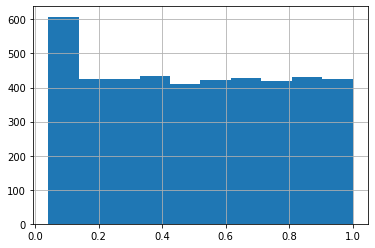

In [0]:
dummy['rank'].hist()

In [0]:
dummy['prop'] = dummy['prop'].astype(float)
dummy = dummy.dropna(subset = ['prop'])

In [0]:
a = dummy[dummy['prop'] < 0.00001]
print(len(a)/len(dummy))

0.08344640434192672


In [0]:
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages("quantreg")
qtreg = rpackages.importr("quantreg")

tmp = pd.DataFrame()
tmp['prop'] = dummy['prop']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

tmp = tmp.dropna(subset = ['prop'])

'''for ind in tmp.index:
  if tmp['prop'][ind] == 0.0:
    tmp['prop'][ind] = 0.00001'''

#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #gmale = -0.05918, p -> 0.0454 *
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #est Gmale = 0.332419, p val = 0.0312 *
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig




with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = qtreg.rq("prop ~ gender+year+Field_English+q",
                  data=tst_df, tau = 0.50) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
#print(base.summary(model))
print(base.summary(model,se = "nid"))


Call: (function (formula, tau = 0.5, data, subset, weights, na.action, 
    method = "br", model = TRUE, contrasts = NULL, ...) 
{
    call <- match.call()
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action"), 
        names(mf), 0)
    mf <- mf[c(1, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1]] <- as.name("model.frame")
    mf <- eval.parent(mf)
    if (method == "model.frame") 
        return(mf)
    mt <- attr(mf, "terms")
    weights <- as.vector(model.weights(mf))
    tau <- sort(unique(tau))
    eps <- .Machine$double.eps^(2/3)
    if (any(tau == 0)) 
        tau[tau == 0] <- eps
    if (any(tau == 1)) 
        tau[tau == 1] <- 1 - eps
    Y <- model.response(mf)
    if (method == "sfn") {
        if (requireNamespace("MatrixModels", quietly = TRUE) && 
            requireNamespace("Matrix", quietly = TRUE)) {
            X <- MatrixModels::model.Matrix(mt, data, sparse = TRUE)
            vnames <- dimnames(X)[[2]]


In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')

In [0]:
tmp = pd.DataFrame()
tmp['prop'] = dummy['prop']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

tmp = tmp.dropna(subset = ['prop'])

for ind in tmp.index:
  if tmp['prop'][ind] == 0.0:
    tmp['prop'][ind] = 0.00001

#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #gmale = -0.05918, p -> 0.0454 *
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #est Gmale = 0.332419, p val = 0.0312 *
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #insig
tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig




with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("prop ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('Gamma(link = "log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
tmp = pd.DataFrame()
tmp['prop'] = dummy['prop']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

tmp = tmp.dropna(subset = ['prop'])


#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #est Gmale = -0.007596, p val = 0.050 .
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] # Gmale = 0.0610953, p val = 0.0535 .
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig


##hitgher value: more positive means more conservative

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("prop ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
f = df1[df1['G'] == "Female"]
m = df1[df1['G'] == "Male"]
print("mean proportion of uncertain sentence for female ",f['prop'].mean()," and male ",m['prop'].mean())

mean proportion of uncertain sentence for female  0.15010968406118735  and male  0.14327758237785396


In [0]:
un = df1[df1['prop'] > 0]
certain = df1[df1['prop'] == 0.0]
print(len(un)," ",len(certain))

unf = un[un['G'] == "Female"]
certainf = certain[certain['G'] == "Female"]

print("proportion of female in uncertain group ",len(unf)/len(un)," and certain group ",len(certainf)/len(certain))

10662   1468
proportion of female in uncertain group  0.25980116300881634  and certain group  0.22547683923705722


#### regression on vader sentiment

In [0]:
df2 = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/full_vader_reg.csv")
print(df2.dtypes)
print(df2.head(5))

dfpos = df2.groupby('doi')['positive'].mean().reset_index()
dfneg = df2.groupby('doi')['negative'].mean().reset_index()
dfneu = df2.groupby('doi')['neutral'].mean().reset_index()


doi           object
media         object
total_cnt      int64
positive     float64
negative     float64
neutral      float64
compound     float64
G             object
dtype: object
                             doi         media  total_cnt  positive  negative  \
0  10.1080/19320248.2018.1512931        yahoo!         35  0.033229  0.071514   
1   10.1016/j.celrep.2018.10.010  newscientist         14  0.031643  0.045714   
2    10.1126/scirobotics.aat1853       nbcnews         18  0.048500  0.017778   
3    10.1016/j.joule.2018.05.006      gulfnews         31  0.058677  0.033065   
4     10.1016/j.matt.2021.06.009      labroots          9  0.045778  0.041444   

    neutral  compound       G  
0  0.895257 -0.088334  Female  
1  0.922643  0.002100    Male  
2  0.933722  0.029033  Female  
3  0.908258  0.117494    Male  
4  0.912889 -0.035144    Male  


In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
print(total.dtypes)

print("len of total ", len(total))
print(total['doi'].nunique())
total = total.drop_duplicates(subset = ['doi'])

print("len of total after dropping duplicate dois ", len(total))

#total['cor_gender'].unique() //array(['female', 'male', 'M', 'F', 'f', 'm'], dtype=object)
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
print(len(total))
total2 = total[~total['doi'].isin(ids_to_remove)]
print(len(total2))
us = total2[total2['country_name'] == 'United States']
print(len(us))
print(len(us[us['news_cnt'] > 0]))
print(len(us[us['news_cnt'] <= 0]))
print(us.dtypes)

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
dtype: object
len of total  1014175
1014077
len of total after dropping duplicate dois  1014077
1014077
1014035
1014035
129428
884607
Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            obj

In [0]:
merged_pos = dfpos.merge(us, on = 'doi', how = 'inner')
merged_neu = dfneu.merge(us, on = 'doi', how = 'inner')
print(len(merged_pos)," ",len(merged_neu))

4422   4422


In [0]:
dummy = merged_pos.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

4422


Out[44]: <AxesSubplot:>

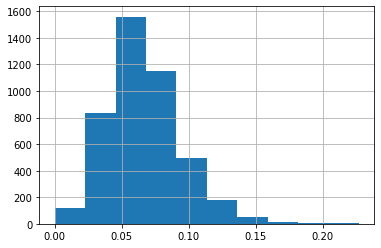

In [0]:
dummy['positive'].hist()

In [0]:
q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

In [0]:
tmp = pd.DataFrame()
tmp['positive'] = dummy['positive']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']


#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig




with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("positive ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
dummy = merged_neu.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

4422


In [0]:
q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

Out[53]: <AxesSubplot:>

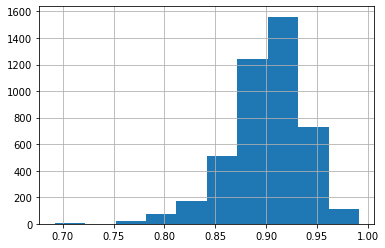

In [0]:
dummy['neutral'].hist()

In [0]:
tmp = pd.DataFrame()
tmp['neutral'] = dummy['neutral']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

#overall - gmale = +ve, p - *
#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #insig
tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #gmale = +ve, **
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig




with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("neutral ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
merged_neg = dfneg.merge(us, on = 'doi', how = 'inner')
print(dfneg['negative'].min())

dummy = merged_neg.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q



0.0
4422


In [0]:
tmp = pd.DataFrame()
tmp['negative'] = dummy['negative']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

#overall - gmale = -ve, insig
#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #insig
tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #gmale = -0.0074305, **
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig




with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("negative ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
#https://quantifyinghealth.com/interpret-linear-regression-coefficients/

Out[93]: <AxesSubplot:>

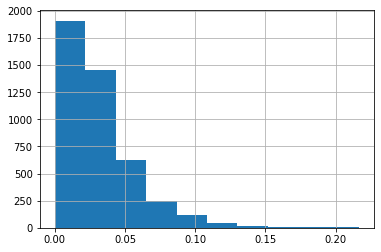

In [0]:
merged_neg['negative'].hist()

In [0]:
len(merged_neg[merged_neg['negative'] <= 0.00001])

Out[102]: 127

In [0]:
merged_neg = dfneg.merge(us, on = 'doi', how = 'inner')
print(dfneg['negative'].min())

dummy = merged_neg.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q


0.0
4422


In [0]:
tmp = pd.DataFrame()
tmp['negative'] = dummy['negative']
tmp['gender'] = dummy['gender']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

#overall - gmale = -ve, insig
#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #insig
tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #gmale = -0.17154, **
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig

for ind in tmp.index:
  if tmp['negative'][ind] == 0.00:
    tmp['negative'][ind] = 0.00001


with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("negative ~ gender+year+Field_English+q",
                  data=tst_df,family=ro.r('Gamma(link="log")')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

#### special media analysis

In [0]:
import pandas as pd

#load the saved us data
t = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")

#only extract the data that has media citation
ff = t[t['news_cnt'] > 0]
print("number of unique doi in cited us data ",ff['doi'].nunique())
print("length of total data ",len(ff))

#remove the retracted dois
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total = ff[~ff['doi'].isin(ids_to_remove)]
print("length of data after removing retracted ids ",len(total))
print("length of unique doi after removing retracted ids ",total['doi'].nunique())
print("total mention ",total['news_cnt'].sum())
total = total.drop_duplicates(subset = ['doi'])
print("len of total after dropping duplicate dois ",len(total))

#merge dois with the media outlet names
m = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_media_for_databricks.csv")
media = m.toPandas()
new_total =total.merge(media, on = ['doi'], how = 'inner') 
print("len of total mention ",len(new_total))
print("len of unique doi in merged data ",new_total['doi'].nunique())
print(new_total['media'].nunique())

print(new_total['doi'].nunique())
print(len(new_total))
a = new_total.drop_duplicates(subset = ['doi','media'])
print(a['doi'].nunique())
print(len(a))
print(a['news_cnt'].min())

 


number of unique doi in cited us data  129439
length of total data  129451
length of data after removing retracted ids  129440
length of unique doi after removing retracted ids  129428
total mention  1405538
len of total after dropping duplicate dois  129428
len of total mention  1405448
len of unique doi in merged data  129428
5113
129428
1405448
129428
1195149
1


In [0]:
samp = a.copy()
#samp = total.copy()
gender = []
for ind in samp.index:
  if samp['cor_gender'][ind] == 'female' or samp['cor_gender'][ind] == 'f' or samp['cor_gender'][ind] == 'F':
    gender.append('Female')
  elif samp['cor_gender'][ind] == 'male' or samp['cor_gender'][ind] == 'm' or samp['cor_gender'][ind] == 'M':
    gender.append("Male")
samp['gender'] = gender

In [0]:
msn = samp[samp['media'] == 'msn']
print(len(msn[msn['gender'] == "Female"])/len(msn))


yah = samp[samp['media'] == 'yahoo!']
print(len(yah[yah['gender'] == "Female"])/len(yah))

nytimes = samp[samp['media'] == 'newyorktimes']
print(len(nytimes[nytimes['gender'] == "Female"])/len(nytimes))

newyorker = samp[samp['media'] == 'thenewyorker']
print(len(newyorker[newyorker['gender'] == "Female"])/len(newyorker))

cnn = samp[samp['media'] == 'cnnnews']
print(len(cnn[cnn['gender'] == "Female"])/len(cnn))

wpost = samp[samp['media'] == 'washingtonpost']
print(len(wpost[wpost['gender'] == "Female"])/len(wpost))

ustoday = samp[samp['media'] == 'usatoday']
print(len(ustoday[ustoday['gender'] == "Female"])/len(ustoday))

yah2 = samp[samp['media'] == 'yahoo!news']
print(len(yah2[yah2['gender'] == "Female"])/len(yah2))

google = samp[samp['media'] == 'googlenews']
print(len(google[google['gender'] == "Female"])/len(google))

npr = samp[samp['media'] == 'npr']
print(len(npr[npr['gender'] == "Female"])/len(npr))

abc = samp[samp['media'] == 'abcnews']
print(len(abc[abc['gender'] == "Female"])/len(abc))

nbc = samp[samp['media'] == 'nbcnews']
print(len(nbc[nbc['gender'] == "Female"])/len(nbc))

cbs = samp[samp['media'] == 'cbsnews']
print(len(cbs[cbs['gender'] == "Female"])/len(cbs))

pbs = samp[samp['media'] == 'pbs']
print(len(pbs[pbs['gender'] == "Female"])/len(pbs))

bbc = samp[samp['media'] == 'bbcnews']
print(len(bbc[bbc['gender'] == "Female"])/len(bbc))

fox = samp[samp['media'] == 'foxnews']
print(len(fox[fox['gender'] == "Female"])/len(fox))

wax = samp[samp['media'] == 'washingtonexaminer']
print(len(wax[wax['gender'] == "Female"])/len(wax))

nmax = samp[samp['media'] == 'newsmax']
print(len(nmax[nmax['gender'] == "Female"])/len(nmax))

blz = samp[samp['media'] == 'theblaze']
print(len(blz[blz['gender'] == "Female"])/len(blz))

wtimes = samp[samp['media'] == 'washingtontimes']
print(len(wtimes[wtimes['gender'] == "Female"])/len(wtimes))

nrev = samp[samp['media'] == 'nationalreview']
print(len(nrev[nrev['gender'] == "Female"])/len(nrev))

cnbc = samp[samp['media'] == 'cnbc']
print(len(cnbc[cnbc['gender'] == "Female"])/len(cnbc))

latimes = samp[samp['media'] == 'losangelestimes']
print(len(latimes[latimes['gender'] == "Female"])/len(latimes))

forbes = samp[samp['media'] == 'forbes']
print(len(forbes[forbes['gender'] == "Female"])/len(forbes))

newsweek = samp[samp['media'] == 'newsweek']
print(len(newsweek[newsweek['gender'] == "Female"])/len(newsweek))

nypost = samp[samp['media'] == 'newyorkpost']
print(len(nypost[nypost['gender'] == "Female"])/len(nypost))

buzzfeed = samp[samp['media'] == 'buzzfeed']
print(len(buzzfeed[buzzfeed['gender'] == "Female"])/len(buzzfeed))

bb = samp[samp['media'] == 'bloomberg']
print(len(bb[bb['gender'] == "Female"])/len(bb))

ct = samp[samp['media'] == 'chicagotribune']
print(len(ct[ct['gender'] == "Female"])/len(ct))

0.3912423080353162
0.4170134842683536
0.3866035675282126
0.2112676056338028
0.4033297529538131
0.39290780141843973
0.3812807881773399
0.4033547714236051
0.2793129200896191
0.4027093596059113
0.38057324840764334
0.4174397031539889
0.3595744680851064
0.3514018691588785
0.3954659949622166
0.3342857142857143
0.36619718309859156
0.3903830480847596
0.2846715328467153
0.32642487046632124
0.36792452830188677
0.3384223918575064
0.3855302279484638
0.38144329896907214
0.34964622641509435
0.3368055555555556
0.38613861386138615
0.3125
0.38248175182481753


In [0]:
len(samp[samp['media'] == 'chicagotribune'])

Out[58]: 685

In [0]:
from scipy.stats import percentileofscore

#dummy = merged.copy()
xx = pd.DataFrame()
xx['score'] = [0,0.1,0.2,0.15,0.34, 0.75,0.55, 0.65]
xx['rank'] = xx['score'].apply(lambda x: percentileofscore(xx['score'], x, kind='rank'))
print(xx)

   score   rank
0   0.00   12.5
1   0.10   25.0
2   0.20   50.0
3   0.15   37.5
4   0.34   62.5
5   0.75  100.0
6   0.55   75.0
7   0.65   87.5


In [0]:
import numpy as np
print(xx['score'].quantile(0.14))
print(np.percentile(xx['score'], 14))

0.09800000000000002
0.09800000000000002


In [0]:
import seaborn as sns

a = sns.color_palette(palette='tab20')
print(a.as_hex())

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
